Risk Management Project #1
Pricing Options using the Black-Scholes-Merton Model (with Binomial Pricing Model)

Allen Jerry Aries

In [45]:
#installing required packages
!pip install yfinance
!pip install pandas_market_calendars
!pip install yahoo_fin
!pip install yahoo_fin mibian

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mibian: filename=mibian-0.1.3-py3-none-any.whl size=4026 sha256=cb7e928f0af9fdc26b43f6bb930c4336a2a4bd748723b7196b51493afbb6ecbe
  Stored in directory: c:\users\u015063\appdata\local\pip\cache\wheels\43\b9\31\945abf284df5614e45ec4fccb8a892025987093558c94902fb
Successfully built mibian


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import math
from scipy.stats import norm
import pandas_market_calendars as mcal
from yahoo_fin import options, stock_info
import mibian
import random

# 1. Selection of the Stock ('TSLA' = Tesla and Downloading Adjusted Closed Prices from Yahoo! Finance 

In [2]:
start_date = '2022-01-01'
end_date = '2022-12-31'
ticker = 'TSLA'
data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
data = pd.DataFrame(data)
data.head()

,Adj Close
Date,
2022-01-03,399.926666
2022-01-04,383.196655
2022-01-05,362.706665
2022-01-06,354.899994
2022-01-07,342.320007


<AxesSubplot:xlabel='Date'>

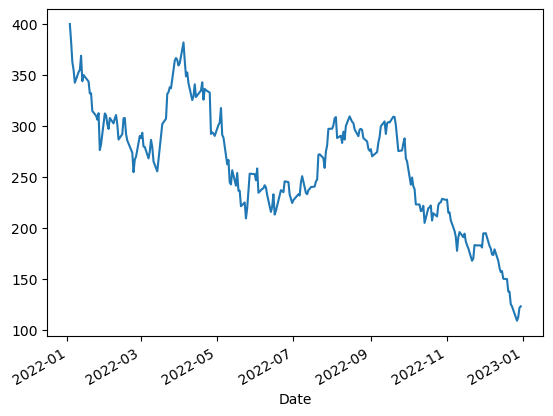

In [4]:
data['Adj Close'].plot()

Calculation of the daily returns:

<AxesSubplot:xlabel='Date'>

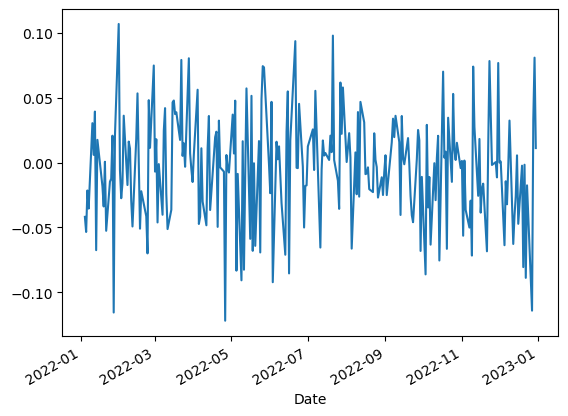

In [5]:
data['returns'] = data['Adj Close'].pct_change().dropna()
data['returns'].plot()

# 2. Choosing and Estimation of the necessary parameters for option pricing

a.  A projection period of 365 days is chosen while the US risk free rate given on 06 March 2023 is r = 3.97% and taken from https://ycharts.com/indicators/10_year_treasury_rate

In [6]:
r = 0.0397
T= 1 #year

b. The projection period "T": T =  1year = 365 days, the same period used for the market data, and the risk 

c. Calculation of the annualized volatility:

In [7]:
t = len(data[data['Adj Close']>0]) #actual trading days

In [8]:
print(f'There are {t} days for which Tesla was traded in 2022.')


There are 251 days for which Tesla was traded in 2022.


In [9]:
data['Deviations'] = data['returns'] - np.mean(data['returns'])
data['Squared Deviations'] = data['Deviations'].apply(lambda x: x**2)
daily_volatility  = np.sqrt(np.sum(data['Squared Deviations'])/(t-1))
print(data)
print(daily_volatility)

             Adj Close   returns  Deviations  Squared Deviations
Date                                                            
2022-01-03  399.926666       NaN         NaN                 NaN
2022-01-04  383.196655 -0.041833   -0.037985            0.001443
2022-01-05  362.706665 -0.053471   -0.049624            0.002463
2022-01-06  354.899994 -0.021523   -0.017676            0.000312
2022-01-07  342.320007 -0.035447   -0.031599            0.000999
...                ...       ...         ...                 ...
2022-12-23  123.150002 -0.017551   -0.013703            0.000188
2022-12-27  109.099998 -0.114089   -0.110241            0.012153
2022-12-28  112.709999  0.033089    0.036936            0.001364
2022-12-29  121.820000  0.080827    0.084674            0.007170
2022-12-30  123.180000  0.011164    0.015012            0.000225

[251 rows x 4 columns]
0.04107304878434106


# 3. Pricing a European Put using the BSM Option Pricing Model

a. Estimating the price of the put:

I. Strike Price X is calculated from the mean µ of the market data

In [10]:
X1 = data['Adj Close'].mean()
print("{:.2f}".format(X1))

263.09


II. Strike Price is set to be 10% of the current market price

Obtaining the current market price:

In [11]:
today = datetime.today().strftime('%Y-%m-%d')
S = yf.download(ticker, start=today, end=today)['Adj Close']
data_found = False

i = 0
while not data_found:
    i = i + 1
    available_date = (datetime.today() - timedelta(days=i)).strftime('%Y-%m-%d')
    try:
        if S.empty:
            S = yf.download(ticker, start=available_date, end=today)['Adj Close']
        
        if not S.empty:
            print(S)
            data_found = True
        
    except:
        continue
S = S.values[0]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSLA: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
Date
2023-03-24    190.410004
Name: Adj Close, dtype: float64


Setting the strike price to be 10% more than the current market price:

In [12]:
X2 = S*1.1
print(f'Current market price is {S:.2f}')
print("{:.2f}".format(X2))

Current market price is 190.41
209.45


Definition of the European Put Function:

$d_1 = \frac{\ln \big(\frac{S_{0}}{K}\big) + (r + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}$ 

$d_2 = d_{1} - \sigma \sqrt{T}$


$P_{0} = X e^{-rT}[1 - N(d_{2})] - S_{0}[1-N(d_{1})]$

where

$N(x) = \int_{-\infty}^x \frac{1}{\sqrt{2\pi}}e^{\frac{-x^{2}}{2}} dx$, the standard normal cummulative probability density


In [13]:
sigma =  annualized_volatility   = daily_volatility* np.sqrt(t)
print(sigma)

0.6507194706220615


In [14]:
def european_put(S, X, T, r, sigma):

    d1 = (np.log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)

    put_price = X*math.exp(-r*T)*(1-N_d2) - S*(1-N_d1)

    return put_price

Case I:

In [15]:
P_01 = max(0,european_put(S, X1, T, r, sigma))

print(f'For a Current Stock Price of {S:.2f}, Strike Price of {X1:.2f}, and a projection period of 1 year, the put price should be {P_01:.2f}.')

For a Current Stock Price of 190.41, Strike Price of 263.09, and a projection period of 1 year, the put price should be 92.82.


Case II:

In [16]:
P_02 = max(0,european_put(S, X2, T, r, sigma))
print(f'For a Current Stock Price of {S:.2f}, Strike Price of {X2:.2f} equal to 10% of the current stock price, the put price should be {P_02:.2f}.')

For a Current Stock Price of 190.41, Strike Price of 209.45 equal to 10% of the current stock price, the put price should be 55.58.


b. Estimation of the respective call prices using the Parity Condition

In [17]:
C_01  = P_01 + S - X1*math.exp(-r*T)
print("{:.2f}".format(C_01))

30.38


In [18]:
C_02  = P_02 + S - X2*math.exp(-r*T)
print("{:.2f}".format(C_02))

44.69


c. Payoff and PnL of the calls

In [19]:
call_payoff_1 = max(0, S - X1)
print("{:.2f}".format(call_payoff_1))

0.00


In [20]:
call_pnl_1 = call_payoff_1 - C_01
print("{:.2f}".format(call_pnl_1))

-30.38


In [21]:
call_payoff_2 = max(0, S - X2)
print("{:.2f}".format(call_payoff_1))

0.00


In [22]:
call_pnl_2 = call_payoff_2 - C_02
print("{:.2f}".format(call_pnl_2))

-44.69


d) Bonus Question: Estimation of the Price of an American Call using the Binomial Options Pricing Model

Estimation of the up and down factors:

$U = e^{\sigma\sqrt{t}}$

$D = e^{-\sigma\sqrt{t}}$

Estimation of Risk-Neutral Probabilities:

$\pi_{u} = \frac{e^{rt}-D}{U-D}$

$\pi_{d} = 1 - \pi_{u}$

Calculation of the price of the underlying asset after 1 period:

$S_{U} = S_{0}U$

$S_{D} = S_{0}D$

Calculation of the option price after 1 year:

$C_{U} = \max(0, S_{U} - X)$

$C_{D} = \max(0, S_{D} - X)$

Estimation of the Expected Value of the Call Option after 1 period:

$C_{0}' = C_{U}\pi_{u} + C_{D}\pi_{d}$


Evaluating the expected value of the call option today:

$C_{0} = C_{0}' e^{-rT}$

In [23]:
#Implementation
def american_call_bopm(S,X,sigma,r,T):
    U = math.exp(sigma*np.sqrt(T))
    D = math.exp(-sigma*np.sqrt(T))
    pi_u = (math.exp(r*T)-D) / (U-D)
    pi_d = 1 - pi_u
    S_U = S*U
    S_D = S*D
    C_U = max(0, S_U - X)
    C_D= max(0, S_D - X)
    C_0_prime = C_U*pi_u + C_D*pi_d
    C_0 = C_0_prime*math.exp(-r*T)
    return C_0
            
print("{:.2f}".format(american_call_bopm(S, X1, sigma, r, T)))

36.42


4. Greeks

$\Delta_{call} = N(d_{1})$

$\Delta_{put} = N(d_{1})-1$

$\Gamma = \frac{N'(d_{1})}{S_{0}\sqrt{T}}$

$\Theta_{call} =  - \frac{S_{0} N'(d_{1}) \sigma} {2 \sqrt{T}} - rXe^{-rT}N(d_{2})$

$\Theta_{put} =  - \frac{S_{0} N'(d_{1}) \sigma} {2 \sqrt{T}} + rXe^{-rT}N(-d_{2})$

$\nu = S_{0}N'(d_{1}) \sqrt{T}$

$\rho_{call} = XTe^{-rT}N(d_{2})$

$\rho_{put} = -XTe^{-rT}N(-d_{2})$

In [24]:
def greeks(S,X,r,T, sigma):
    d1 = (np.log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    N_d1 = delta_call = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    N_d1_prime = norm.pdf(d1)
    N_d2_prime = norm.pdf(d2)
    delta_put = delta_call - 1
    gamma = N_d1_prime/(S*np.sqrt(T))
    theta_call = -S*(N_d1_prime*sigma/(2*np.sqrt(T)))  - r*X*math.exp(-r*T)*N_d2
    theta_put = -S*(N_d1_prime*sigma/(2*np.sqrt(T))) + r*X*math.exp(-r*T)*N_d2
    vega = S*N_d1_prime*np.sqrt(T)
    rho_call = X*T*math.exp(-r*T)*(N_d2)
    rho_put = -X*T*math.exp(-r*T)*(1-N_d2)
    return delta_call, delta_put, gamma, theta_call, theta_put, vega, rho_call, rho_put    

In [25]:
#Taking Case I as an example.
delta_call, delta_put, gamma, theta_call, theta_put, vega, rho_call, rho_put   = greeks(S, X1, r, T, sigma)
print(f'Delta: If the asset prices increase by $1, the call price will increase by ${delta_call:.2f} while a corresponding put option will increase/decrease by ${delta_put:.2f}.')
print(f'Gamma: If the asset prices increase by $1, the delta of the option will change by {gamma:.4f}.')
print(f'Theta: The call and the put price will respectively decrease by {theta_call/t:.2f} and {theta_put/t:.2f} daily.')

Delta: If the asset prices increase by $1, the call price will increase by $0.46 while a corresponding put option will increase/decrease by $-0.54.
Gamma: If the asset prices increase by $1, the delta of the option will change by 0.0021.
Theta: The call and the put price will respectively decrease by -0.11 and -0.09 daily.


In [26]:
delta_call, delta_put, gamma, theta_call, theta_put, vega, rho_call, rho_put   = greeks(S, X1, r, T, (1-0.019)*sigma)
print(f'Vega: A 1.9% decrease in volatility will decrease the price of an option by {vega}.')

Vega: A 1.9% decrease in volatility will decrease the price of an option by 75.37020484777756.


In [27]:
delta_call, delta_put, gamma, theta_call, theta_put, vega, rho_call, rho_put = greeks(S, X1, r+0.007, T, sigma)
print(f'Rho: A 0.7% increase in the risk-free rate will increase/decrease the call and option price by {rho_call} and {rho_put:.2f} respectively.')


Rho: A 0.7% increase in the risk-free rate will increase/decrease the call and option price by 56.86804676850614 and -194.22 respectively.


5. Delta Hedging

a) Assuming you are long 15 000 shares of your chosen asset, determine the number of options necessary to create a delta neutral portfolio (use a Covered Call or a Protective Put strategy) Interpret the result

b) Estimate the effect on your delta neutral portfolio if the market price of your asset increases by $0.67 Interpret the result

c) What is the impact on delta after the $0.67 increase? How should you rebalance your portfolio to maintain the delta hedge? Make the necessary calculations and interpret the result

In [28]:
#taking Case I as an example:
#a
#Covered Call Strategy
delta_call, delta_put, gamma, theta_call, theta_put, vega, rho_call, rho_put = greeks(S, X1, r, T, sigma)

shares =  15000

number_of_calls_deltahedge = shares / delta_call

options_per_contract = 100

print(f'Number of Calls needed to Delta Hedge: {math.ceil(number_of_calls_deltahedge)}')
print(f'Number of Standard Contracts needed to Delta Hedge: {math.ceil(number_of_calls_deltahedge/options_per_contract)}')

Number of Calls needed to Delta Hedge: 32895
Number of Standard Contracts needed to Delta Hedge: 329


$d0 = dS*\Delta $

In [29]:
#b
change_asset_price = 0.67
change_option_price = delta_call * change_asset_price
print(f'The call price will also increase by ${change_option_price:.2f} per option.')
print(f'Total Change in the Stock Position: ${change_asset_price*shares:.2f}')
print(f'Total Change in the Option Position: ${number_of_calls_deltahedge*-change_option_price:.2f}.')
print(f'Net Change in the Porftolio Value: ${(change_asset_price*shares+number_of_calls_deltahedge*-change_option_price):.2f}.')
print('The rebalanced delta-neutral portfolio was protected from a small change in the price of the stock.')

The call price will also increase by $0.31 per option.
Total Change in the Stock Position: $10050.00
Total Change in the Option Position: $-10050.00.
Net Change in the Porftolio Value: $-0.00.
The rebalanced delta-neutral portfolio was protected from a small change in the price of the stock.


#c When rebalancing a delta-hedged portfolio, the change in the option's delta ($\Delta$) needs yo be considered due to the change in the underlying asset's price. Let $\Delta_1$ be the initial delta of the option, and $\Delta_2$ be the new delta after the price change:

$\Delta_{2} - \Delta_{1} = \left(\frac{dO}{dS}\right)_{2} - \left(\frac{dO}{dS}\right)_{1}$

Here, $\frac{dO}{dS}$ represents the delta of the option at different points in time, and $O$ and $S$ represent the option price and the underlying stock price, respectively.

Suppose, the initial position holds $N_{\text{contracts}}$ option contracts and $N_{\text{shares}}$ shares of the underlying asset. After the price change, there is a need to adjust the number of option contracts to $N_{\text{contracts}} + \Delta N_{\text{contracts}}$ to maintain a delta-neutral position.

The change in the total delta of the position should be equal to the change in the delta of the option multiplied by the change in the number of contracts:

$N_{\text{shares}} \times (\Delta_{2} - \Delta_{1}) = (\Delta N_{\text{contracts}}) \times \Delta_{\text{option}} \times \text{Options per contract}$

Solving for $\Delta N_{\text{contracts}}$:

$\Delta N_{\text{contracts}} = \frac{N_{\text{shares}} \times (\Delta_{2} - \Delta_{1})}{\Delta_{\text{option}} \times \text{Options per contract}}$


In [30]:
#c
initial_delta = delta_call
d1 = (np.log((S+0.67)/X1) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
new_delta= norm.cdf(d1)
delta_change = new_delta - initial_delta
additional_contracts = shares*delta_change / (new_delta * options_per_contract)
print(f'To maintain the delta hedge, {math.ceil(additional_contracts)} contract(s) need(s) to be added.')

To maintain the delta hedge, 1 contract(s) need(s) to be added.


6. Gamma hedging

a) Create a gamma neutral position in order to protect your portfolio from market risk To hedge, select a random option (specify your source) and its respective delta and gamma values:


A random call contract is selected: 
Call (TSLA 230331C00172500) with 

$\Delta = 0.88252$

$\Gamma = 0.01188$

Source:https://www.nasdaq.com/market-activity/stocks/tsla/option-chain/call-put-options/tsla--230331p00172500

To create a Gamma Neutral Position, a portfolio should be constructed such that total $\Gamma$ of the portfolio will be zero. Supposing the original portfolio has an existing $\Gamma_{1}$ with $n_{1}$ options, and a tradeable option has $\Gamma_{2}$, the number of options, $n_{2}$, required for the latter, to creat a gamma neutral portfolio should satisfy:

$\Gamma_{1}n_{1} + \Gamma_{2}n_{2} = 0 $

$ n_{2} = -n_{1} \Big(\frac{\Gamma_{1}}{\Gamma_{2}}\Big) $

In [31]:
sigma = annualized_volatility
delta_call, delta_put, gamma, theta_call, theta_put, vega, rho_call, rho_put = greeks(S, X1, r, T, sigma)
gamma1 = gamma
gamma2 = 0.01188
print(gamma1)
print(gamma2)
n1 = number_of_calls_deltahedge
n2 = -n1*gamma1/gamma2
print(math.floor(n2))

0.0020824206113580854
0.01188
-5767


In [32]:
print(f'Therefore {math.ceil(-n2)} call options need to be shorted(writing (selling to open)) to create a gamma neurtal portfolio')
print(f'This corresponds to about {math.ceil(-n2/100)} call contracts.')

Therefore 5767 call options need to be shorted(writing (selling to open)) to create a gamma neurtal portfolio
This corresponds to about 58 call contracts.


b) Based on the result in 5 b), how should you adjust your portfolio to maintain a delta gamma neutral position Make the necessary calculations and interpret the result

The result in 5.b resulted in delta neutral position. However by adjusting the portfolio, the original gamma will be affected.  Hence:

In [33]:
delta1, _, gamma1, _, _, _, _, _ =  greeks(S, X1, r, T, sigma)
delta2, _, gamma2, _, _, _, _, _ =  greeks(S+0.67, X1, r, T, sigma)

#The delta has already been maintained in 5.b and c. To maintain the gamma neutrality:
additional_options = shares*(delta2-delta1) / (delta2)
n1 = number_of_calls_deltahedge
n2 = number_of_calls_deltahedge + additional_options

#To maintain gamma-neutrality:

gamma_add = n2*(gamma2-gamma1) / (gamma2)
print(f'There is a need to add {math.ceil((n2-n1)/100)} contract to maintain delta-neutrality as mentioned in (5).')
print(f'There is a need to short {-math.floor(gamma_add/100)} call contract from the new portfolio to maintain gamma neutrality.')


There is a need to add 1 contract to maintain delta-neutrality as mentioned in (5).
There is a need to short 1 call contract from the new portfolio to maintain gamma neutrality.
